##################################################################
#### Prepared for the textbook:
#### Data Analysis for Business, Economics, and Policy
#### by Gabor BEKES (Central Europen University) and  Gabor KEZDI (University of Michigan)
#### Cambridge University Press 2020

#### License: Free to share, modify and use for educational purposes. 
#### Not to be used for business purposes
#### 
####
##################################################################
#### CHAPTER 7
#### Regression
#### Hotels dataset
#
#### v 1.0

### Import libraries and set folders

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import seaborn as sns
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np

# Current script folder
current_path = os.getcwd()
dirname = "/".join(current_path.split("/")[:-2]) + "/"
# location folders
data_in = dirname + "da_data_repo/hotels-vienna/clean/"
data_out = dirname + "da_case_studies/ch03-hotels-vienna-explore/"
output = dirname + "da_case_studies/ch03-hotels-vienna-explore/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)
# Import the prewritten helper functions
from py_helper_functions import *

In [4]:
# load vienna
hotels = pd.read_csv(data_in+"hotels-vienna.csv")

In [5]:
####SAMPLE SELECTION
# Apply filters:  3-4 stars, Vienna actual, without  extreme value
hotels = (
    hotels.query('accommodation_type=="Hotel"')
    .query('city_actual=="Vienna"')
    .query("stars>=3 & stars<=4")
    .query("stars.notna()")
    .query("price<=600")
)

In [6]:
hotels

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,offer_cat,year,month,weekend,holiday,distance,distance_alter,accommodation_type,nnights,rating
1,Austria,Vienna,189.0,City centre,Donauturm,17. Hernals,81,Vienna,4.0,3.5,...,1-15% offer,2017,11,0,0,1.7,3.8,Hotel,1,3.9
2,Austria,Vienna,53.0,City centre,Donauturm,Alsergrund,85,Vienna,4.0,3.5,...,15-50% offer,2017,11,0,0,1.4,2.5,Hotel,1,3.7
3,Austria,Vienna,55.0,City centre,Donauturm,Alsergrund,83,Vienna,3.0,4.0,...,15-50% offer,2017,11,0,0,1.7,2.5,Hotel,1,4.0
4,Austria,Vienna,33.0,City centre,Donauturm,Alsergrund,82,Vienna,4.0,3.5,...,15-50% offer,2017,11,0,0,1.2,2.8,Hotel,1,3.9
6,Austria,Vienna,57.0,City centre,Donauturm,Alsergrund,103,Vienna,4.0,3.5,...,0% no offer,2017,11,0,0,0.9,2.4,Hotel,1,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,Austria,Vienna,77.0,City centre,Donauturm,Wieden,100,Vienna,3.0,4.0,...,1-15% offer,2017,11,0,0,1.2,3.7,Hotel,1,4.0
421,Austria,Vienna,572.0,City centre,Donauturm,Wieden,95,Vienna,4.0,4.0,...,1-15% offer,2017,11,0,0,1.5,3.9,Hotel,1,4.1
422,Austria,Vienna,53.0,City centre,Donauturm,Wieden,73,Vienna,3.0,3.0,...,1-15% offer,2017,11,0,0,1.5,4.0,Hotel,1,3.4
425,Austria,Vienna,112.0,City centre,Donauturm,Wieden,100,Vienna,4.0,4.5,...,0% no offer,2017,11,0,0,1.0,3.7,Hotel,1,4.4


In [7]:
# save a copy of the work file
hotels.to_csv(data_out+"hotels_work.csv",index=False)

### Summary statistics on price and distance

In [8]:
#Price
hotels[['price']].describe(percentiles=[0.50,0.95])

,price
count,207.000000
mean,109.975845
std,42.221381
min,50.000000
50%,100.000000
95%,183.400000
max,383.000000


In [9]:
# Distance
hotels[['distance']].describe(percentiles=[0.50,0.95])

,distance
count,207.000000
mean,1.529952
std,1.161507
min,0.000000
50%,1.300000
95%,3.900000
max,6.600000


In [10]:
### REGRESSION 1: CLOSE VS FAR REGRESSION WITH BINARY DISTANCE

In [11]:
#hotels=hotels.assign(dist2=lambda x: x.distance>=2)
hotels["dist2"]=hotels.distance.apply(lambda x: int(x>=2))

In [12]:
hotels

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,year,month,weekend,holiday,distance,distance_alter,accommodation_type,nnights,rating,dist2
1,Austria,Vienna,189.0,City centre,Donauturm,17. Hernals,81,Vienna,4.0,3.5,...,2017,11,0,0,1.7,3.8,Hotel,1,3.9,0
2,Austria,Vienna,53.0,City centre,Donauturm,Alsergrund,85,Vienna,4.0,3.5,...,2017,11,0,0,1.4,2.5,Hotel,1,3.7,0
3,Austria,Vienna,55.0,City centre,Donauturm,Alsergrund,83,Vienna,3.0,4.0,...,2017,11,0,0,1.7,2.5,Hotel,1,4.0,0
4,Austria,Vienna,33.0,City centre,Donauturm,Alsergrund,82,Vienna,4.0,3.5,...,2017,11,0,0,1.2,2.8,Hotel,1,3.9,0
6,Austria,Vienna,57.0,City centre,Donauturm,Alsergrund,103,Vienna,4.0,3.5,...,2017,11,0,0,0.9,2.4,Hotel,1,3.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,Austria,Vienna,77.0,City centre,Donauturm,Wieden,100,Vienna,3.0,4.0,...,2017,11,0,0,1.2,3.7,Hotel,1,4.0,0
421,Austria,Vienna,572.0,City centre,Donauturm,Wieden,95,Vienna,4.0,4.0,...,2017,11,0,0,1.5,3.9,Hotel,1,4.1,0
422,Austria,Vienna,53.0,City centre,Donauturm,Wieden,73,Vienna,3.0,3.0,...,2017,11,0,0,1.5,4.0,Hotel,1,3.4,0
425,Austria,Vienna,112.0,City centre,Donauturm,Wieden,100,Vienna,4.0,4.5,...,2017,11,0,0,1.0,3.7,Hotel,1,4.4,0


In [13]:
dist2=hotels.groupby("dist2").aggregate(Eprice_cat2=("price",np.mean))

In [14]:
hotels=hotels.merge(dist2,left_on="dist2",right_on=dist2.index)

In [15]:
hotels.dist2=hotels.dist2.replace(0,"Close")
hotels.dist2=hotels.dist2.replace(1,"Far")

In [16]:
hotels[["dist2","distance","price"]].groupby("dist2").aggregate("describe")

distance                                               price  \
         count      mean       std  min  25%  50%  75%  max  count   
dist2                                                                
Close    157.0  0.994904  0.539325  0.0  0.5  0.9  1.5  1.9  157.0   
Far       50.0  3.210000  0.973789  2.0  2.4  3.1  3.7  6.6   50.0   

                                                                
             mean        std   min    25%    50%    75%    max  
dist2                                                           
Close  116.426752  43.095928  54.0  85.00  109.0  135.0  383.0  
Far     89.720000  32.085371  50.0  74.25   81.5   96.5  208.0

# Figure 7.1a
# PLOT MEAN VALUES BY CLOSE VS FAR

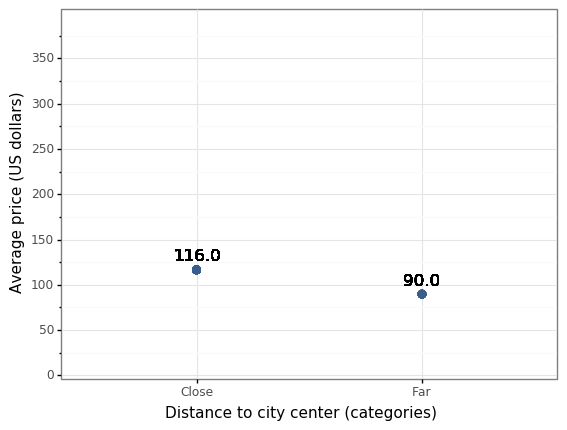

<ggplot: (8768383158411)>

In [17]:
ggplot(hotels) + geom_point(
    aes(x="dist2", y="Eprice_cat2"),
    size=2.5,
    color=color[0],
    fill=color[0],
    alpha=0.4
) + geom_text(
    aes(x="dist2", y="[x+15 for x in Eprice_cat2]", label=np.round(hotels.Eprice_cat2)),
    color="black",
    size=12,
) + scale_y_continuous(
    expand=[0.01, 0.01], limits=[0, 400], breaks=seq(0, 400, 50)
) + expand_limits(
    y=0.01
) + scale_x_discrete() + labs(
    x="Distance to city center (categories)", y="Average price (US dollars)"
) + theme_bw()

In [18]:
hotels["dist4"] = hotels.distance.apply(
    lambda x: 0.5 + 1 * int(x >= 1) + 1 * int(x > 2) + 2.5 * int(x >= 3)
)

In [19]:
dist4 = hotels.groupby("dist4").aggregate(Eprice_cat4=("price", np.mean))

In [20]:
hotels = hotels.merge(dist4, left_on="dist4", right_on=dist4.index)

In [21]:
hotels[["dist4", "distance", "price"]].groupby("dist4").aggregate("describe")

distance                                                  price  \
         count      mean       std  min    25%  50%    75%  max count   
dist4                                                                   
0.5       81.0  0.554321  0.282865  0.0  0.300  0.6  0.800  0.9  81.0   
1.5       80.0  1.491250  0.309836  1.0  1.200  1.5  1.700  2.0  80.0   
2.5       18.0  2.433333  0.299018  2.1  2.100  2.4  2.675  2.9  18.0   
5.0       28.0  3.882143  0.759656  3.0  3.475  3.7  4.100  6.6  28.0   

                                                                  
             mean        std   min     25%    50%     75%    max  
dist4                                                             
0.5    132.913580  38.540627  68.0  110.00  128.0  152.00  242.0  
1.5     97.625000  40.598489  54.0   79.75   90.0  105.25  383.0  
2.5    102.722222  41.378889  69.0   80.25   83.0  100.75  208.0  
5.0     83.571429  22.596998  50.0   68.75   79.0   91.25  156.0

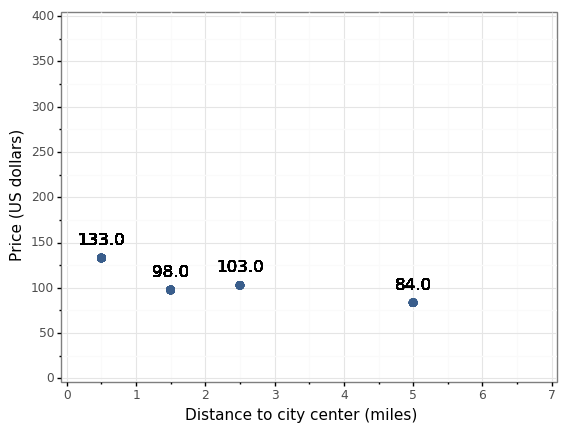

<ggplot: (8768383000203)>

In [22]:
ggplot(data=hotels) + geom_point(
    aes(x="dist4", y="Eprice_cat4"),
    size=2.5,
    color=color[0],
    fill=color[0],
    alpha=0.4,
) + geom_text(
    aes(x="dist4", y="[x+20 for x in Eprice_cat4]", label=np.round(hotels.Eprice_cat4)),
    color="black",
    size=12,
) + expand_limits(
    x=0.01, y=0.01
) + coord_cartesian(
    xlim=[0, 7], ylim=[0, 400]
) + scale_y_continuous(
    expand=[0.01, 0.01], limits=[0, 400], breaks=seq(0, 401, 50)
) + scale_x_continuous(
    expand=[0.01, 0.01], limits=[0, 7], breaks=[0, 1, 2, 3, 4, 5, 6, 7]
) + labs(
    x="Distance to city center (miles)", y="Price (US dollars)"
) + theme_bw()

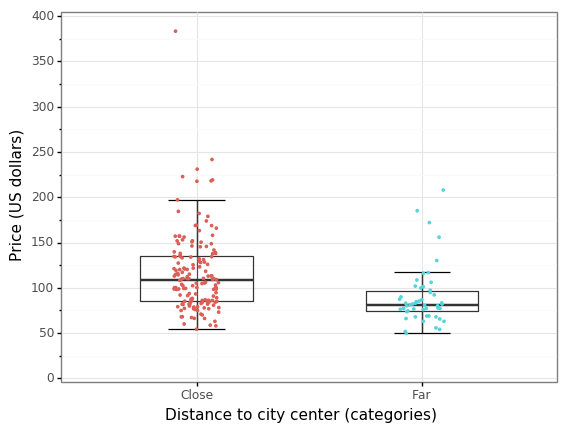

<ggplot: (8768382842697)>

In [23]:
ggplot(hotels, aes(x="dist2", y="price")) + stat_boxplot(
    aes(group="dist2"),
    geom="errorbar",
    width=0.25,
    size=0.5
) + geom_boxplot(
    aes(group="dist2"),
    size=0.5,
    width=0.5,
    alpha=0.3,
    outlier_shape="",
) + geom_jitter(
    aes(color="dist2"), position=position_jitter(0.1), size=0.5, show_legend=False
) + labs(
    x="Distance to city center (categories)", y="Price (US dollars)"
) + scale_y_continuous(
    expand=[0.01, 0.01], limits=[0, 400], breaks=seq(0, 401, 50)
) + expand_limits(
    y=0.01
) + theme_bw()

############
# FIGURE 7.3a 

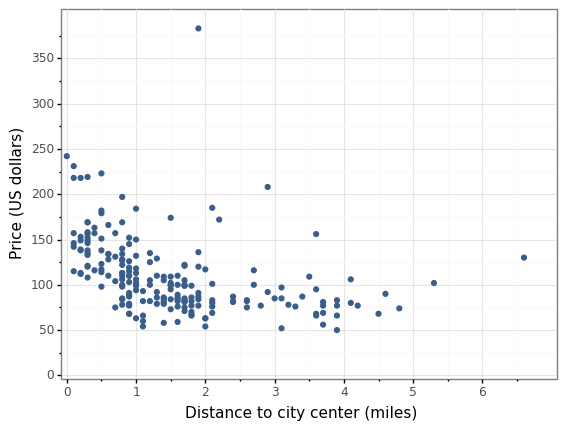

<ggplot: (8768382195402)>

In [26]:
ggplot(hotels, aes(x="distance", y="price")) + geom_point(color=color[0]) + expand_limits(
    x=0.01, y=0.01
) + scale_x_continuous(
    expand=[0.01, 0.01], limits=[0, 7], breaks=seq(0, 7, 1)
) + scale_y_continuous(
    expand=[0.01, 0.01], limits=[0, 400], breaks=seq(0, 400, 50)
) + labs(
    x="Distance to city center (miles)", y="Price (US dollars)"
) + theme_bw()

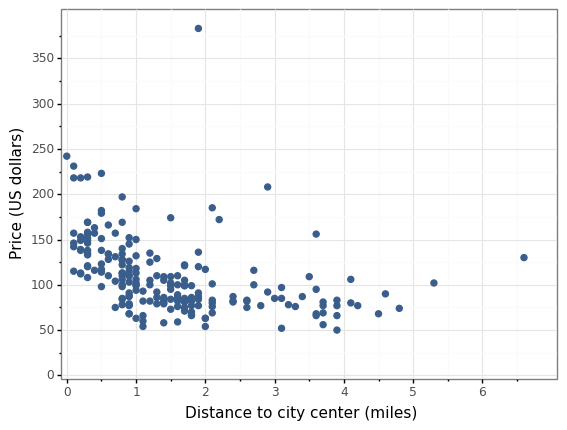

<ggplot: (8768382193231)>

In [28]:
# large sized graphs
ggplot(hotels) + geom_point(
    aes(x="distance", y="price"),
    color=color[0],
    size=2,
    alpha=0.5,
    show_legend=False,
    na_rm=True,
) + expand_limits(x=0.01, y=0.01) + scale_x_continuous(
    expand=[0.01, 0.01], limits=[0, 7], breaks=seq(0, 7, 1)
) + scale_y_continuous(
    expand=[0.01, 0.01], limits=[0, 400], breaks=seq(0, 400, 50)
) + labs(
    x="Distance to city center (miles)", y="Price (US dollars)"
) + theme_bw()

In [31]:
hotels["dist4_s"] = hotels.distance.apply(lambda x:
    1 * int(x >= 1)
    + 1 * int(x >= 2)
    + 1 * int(x >= 3)
    + 1 * int(x >= 4)
    + 1 * int(x >= 5)
    + 1 * int(x >= 6)
)
hotels['xend']=